In [1]:
using EO, Plots, Lasso, CSV, DataFrames, Statistics

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


compiled


In [2]:
N = 10

data = CSV.read("../trading_data/archive(4)/sp500_stocks.csv", DataFrame)
price = filter("Symbol" => x->x == "EA", data).Open

g_fs = Vector{Vector{Float64}}()
l_fs = Vector{Vector{Float64}}()
f_fs = Vector{Vector{Float64}}()

for i in 1:N
    print("\r $i")
    x = collect(2+(i-1)*100:2+(i)*100)

    y = float.(price[x])
    
    domain = float.(x)


    basis_functions = [+, -, *, /, sin, cos, EO.square, EO.cube, EO.logaritmus]
    basis_variables = Vector{Any}([:var1])

    # train GP
    pop_size = 300
    objective_function  = enclose_arguments(EO.f_function_diff_squared, y, domain)
    initialization      = enclose_noargs(EO.expression_initialization, pop_size, objective_function, basis_functions, basis_variables)
    selection           = enclose_arguments(EO.s_tournament, 100, 3)
    crossover           = enclose_arguments(EO.cr_subtree, pop_size, basis_functions, basis_variables)
    mutation            = enclose_arguments(EO.subtree_mutation!, basis_functions, basis_variables)
    replacement         = enclose_replacement(EO.r_best_n_diverse, pop_size, 0.7)       # chosen fraction of the population will consist of the best n, the rest is random
    termination         = enclose_argument(iteration_termination, pop_size*20)
    @time g_f           = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination)

    # train LS
    pop_size = 1
    objective_function  = enclose_arguments(EO.f_function_diff_squared, domain, float.(price[x]))
    initialization      = enclose_noargs(EO.one_expression_initialization, pop_size, objective_function, basis_functions, basis_variables)
    selection           = EO.s_identity
    crossover           = identity
    mutation            = enclose_arguments(EO.subtree_mutation!, basis_functions, basis_variables)
    replacement         = EO.enclose_replacement(r_keep_best_n, 1)
    termination         = enclose_argument(iteration_termination, pop_size*300)
    @time l_f           = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination)

    # train FS
    variables   = [domain]
    operations  = Vector{Function}([+, -, *, EO.protected_div, sin, EO.square, EO.cube, EO.logaritmus])
    arities     = [2,2,2,2,1,1,1,1]
    exprs       = Vector{Any}([:x])
    @time f_f   = EO.feature_synthesis(y, variables, operations, arities, exprs, 100, q=10, μ=3, max_depth=5);

    push!(g_fs, g_f)
    push!(l_fs, l_f)
    push!(f_fs, f_f)
end


 1  8.679889 seconds (53.26 M allocations: 2.113 GiB, 4.48% gc time, 65.95% compilation time)
  0.283398 seconds (2.69 M allocations: 103.776 MiB, 11.54% gc time, 55.71% compilation time)
  3.845895 seconds (1.41 M allocations: 111.384 MiB, 98.95% compilation time)
 2  7.217691 seconds (64.87 M allocations: 2.413 GiB, 14.10% gc time, 2.23% compilation time)
  0.332120 seconds (2.68 M allocations: 98.815 MiB, 20.46% gc time)
  0.066902 seconds (124.76 k allocations: 29.131 MiB)
 3 31.901333 seconds (332.49 M allocations: 12.018 GiB, 11.72% gc time, 0.00% compilation time)
  0.451163 seconds (4.89 M allocations: 181.482 MiB, 8.42% gc time, 7.25% compilation time)
  0.040797 seconds (105.20 k allocations: 25.430 MiB)
 4 21.520022 seconds (287.73 M allocations: 10.547 GiB, 10.65% gc time)
  0.097984 seconds (1.88 M allocations: 70.009 MiB)
  0.032736 seconds (124.98 k allocations: 27.137 MiB)
 5 16.983307 seconds (238.56 M allocations: 8.754 GiB, 11.01% gc time)
  0.144880 seconds (1.48 M 

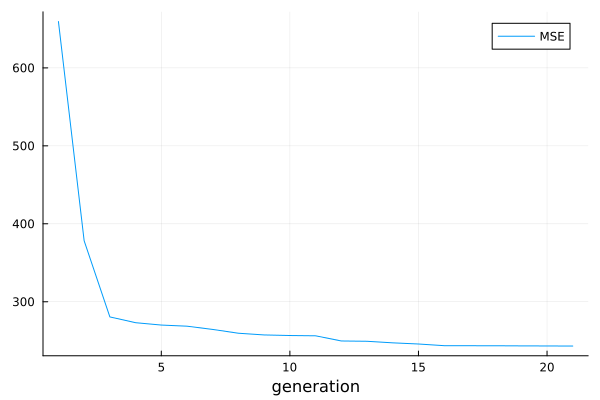

In [10]:
p = plot(mean(g_fs), label="MSE", xlabel="generation")
savefig(p, "../images/GP_training_fitness.svg")
p

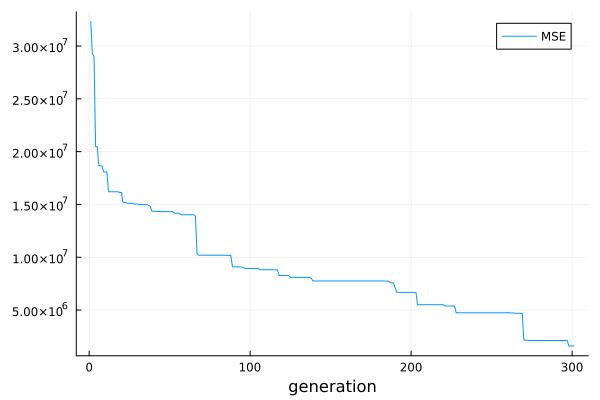

In [11]:
p = plot(mean(l_fs), label="MSE", xlabel="generation")
savefig(p, "../images/LS_training_fitness.svg")
p

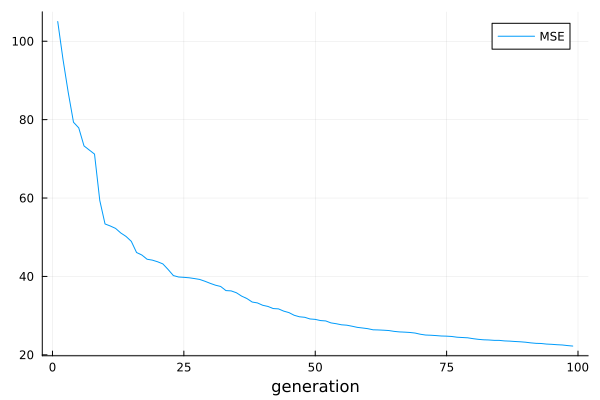

In [12]:
p = plot(mean(f_fs), label="MSE", xlabel="generation")
savefig(p, "../images/FS_training_fitness.svg")
p

In [25]:
using EO, Plots, Lasso, CSV, DataFrames, Statistics, FileIO
training_width = 100
prediction_width = 10
timestep = 10
#strategy = "tree_GP"
#strategy = "LS"
strategy = "FS"

n_errors = []
s_errors = []

names = ["Fuji Electric ADR", "Metal Component Engineering Ltd", "Perdoceo Education", "American Airlines", "3M", "Apple",  "Coca-Cola", "Exxon Mobil", "Ford Motor", "Intel", "Microsoft", "NVIDIA", "Pfizer", "K", "EA"]
for name in names
    if strategy == "tree_GP"
        res, price = load(joinpath(@__DIR__, "evaluations", "tree_GP", name, "predictions.jld2"))["res"];
    elseif  strategy == "LS"
        res, price = load(joinpath(@__DIR__, "evaluations", "LS", name, "predictions.jld2"))["res"];
    elseif  strategy == "FS"
        res, price = load(joinpath(@__DIR__, "evaluations", name, "predictions.jld2"))["res"];
    end

    diffs = Vector{Float64}()
    true_diffs = Vector{Float64}()
    
    i = 1
    for prediction in res
        pr = EO.signal_mean(mean(prediction))
        last_known_val = pr[training_width]
        predicted_val  = pr[training_width+prediction_width]
    
        diff        = 10*(predicted_val - last_known_val)
        true_diff   = price[(2+prediction_width+training_width+timestep*(i-1))] - price[(2+timestep*(i-1))]
    
        push!(diffs, diff)
        push!(true_diffs, true_diff)
        i+=1
    end

    noisy_e = sum((diffs-true_diffs).^2)
    smooth_e = sum((EO.signal_mean(diffs)-EO.signal_mean(true_diffs)).^2)


    push!(n_errors, noisy_e)
    push!(s_errors, smooth_e)

end

In [26]:
# FS
println(names)
println(n_errors)
println(s_errors)
println(sum(n_errors)/sum(s_errors))

["Fuji Electric ADR", "Metal Component Engineering Ltd", "Perdoceo Education", "American Airlines", "3M", "Apple", "Coca-Cola", "Exxon Mobil", "Ford Motor", "Intel", "Microsoft", "NVIDIA", "Pfizer", "K", "EA"]
Any[1780.7885560261368, 0.07064885877986157, 8899.816391216078, 19379.049485358886, 114081.37246810056, 90383.35529500137, 16925.71079490464, 44897.484655173015, 3991.2339586013777, 39945.47745705043, 162299.63205190143, 30064.431449672808, 20268.650277762525, 29532.966097744084, 82697.81256737621]
Any[160.93491375276093, 0.030422819332868504, 544.6655180414956, 7297.533247913579, 25096.133095364403, 5909.683887354274, 1070.185738493742, 4991.6605888887725, 502.81054192763077, 8902.599707243939, 30485.802825318464, 2507.5100414035373, 1045.9550326599833, 1731.7731861378877, 5293.366349662561]
6.961935953850461


In [ ]:
# GP
println(names)
println(n_errors)
println(s_errors)

In [ ]:
# LS
println(names)
println(n_errors)
println(s_errors)